# Setup

## imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
!pip install unidecode
import unidecode
import re
import random

import platform
import time
import pathlib
import os

Defaulting to user installation because normal site-packages is not writeable


execute if running on Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## loadataset_stringified



In [3]:
def load_dataset(silent=False, gColab=False):
    # List of dataset files we want to merge
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []

    if gColab:
        dataset_dir = '/content/drive/MyDrive/foodSuggest/recipes_raw/'
    else:
        dataset_dir = './datasets/recipes_raw/'
    
    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'{dataset_dir}{dataset_file_name}'
        
        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list
            
            # This code block outputs a summary for each dataset.
            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  ingredients: ', json_data_list[0]['ingredients'])
                print('\n\n')

    return dataset  

<code>dataset_raw</code> contains all data, unadulterated

In [4]:
dataset_raw = load_dataset(silent=True, gColab=False)

## preprocess data

Checks if the entry contains a non-empty <code>ingredients</code> section

In [5]:
def validate_required_fields(recipe):
    required_keys = ['ingredients']
    
    # If recipe empty
    if not recipe:
        return False
    
    for required_key in required_keys:
        # If there is no required_key entry in recipe
        if not recipe[required_key]:
            return False
        
        # If the required_key entry is an empty list
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
        
    return True

<code>dataset_validated</code> only possesses recipe entries with a non-empty ingredients list

In [6]:
dataset_validated = [recipe for recipe in dataset_raw if validate_required_fields(recipe)]

<code>skim_and_string</code> returns the <code>ingredients</code> array from a recipe, converting to lowercase, removing weird symbols, converting accented characters to standard ASCII ones, and returning it all as a single string with different ingredients separated by <code>\n</code>

In [18]:
def skim_and_string(recipe):
    symbol_blacklist = [
        '0','1','2','3','4','5','6','7','8','9',
        '/',
        '(',
        ')',
        ',',
        '.',
        "'",
        '®',
        ':',
        '™',
        ';',
        '&',
        '%',
        '*',
        '"',
        '–',
        '°',
        'î',
        '!',
        '½',
        '?',
        '¿',
        '=',
        'ó',
        '¼',
        '>',
        '#',
        '<',
        '’',
        '—',
        ']',
        '[',
        '¾',
        '+',
        '}',
        '_',
        '⁄',
        '{',
        '\xad',
        '|',
        '$',
        '‑',
        '`',
        '‚',
        '\\',
        '•',
        '́',
        '×',
        'õ',
        '@',
        '�',
        'ﬁ',
        '‧',
        '‟',
        '‐',
        '©',
        '§',
        'ﬂ',
        '⅞',
        '⅛',
        '″',
        '‱',
        '”',
        '¤',
        '\x96',
        '~'
    ]
    
    ingred_list = recipe['ingredients']
    
    out = ''
    for ingredient in ingred_list:
        ingredient = ingredient.lower()  # doesn't affect any of the weird symbols above last time I checked

        for bad_symbol in symbol_blacklist:
            ingredient = ingredient.replace(bad_symbol, '')
        
        # transliterates not ASCII characters (should check the entries where these occur to inspect the data to make sure this actions is appropriate)
        ingredient = unidecode.unidecode(ingredient)
        
        # delete leading whitespace
        while ingredient and ingredient[0] == ' ':
            ingredient = ingredient[1::]
        
        # delete trailing whitespace/newlines
        while ingredient and (ingredient[-1] == '\n' or ingredient[-1] == ' '):
            ingredient = ingredient[:-1]
        
        # removes multiple whiespaces
        ingredient = re.sub(' +', ' ', ingredient)

        if ingredient:  # if list non-empty after bad_word purging
            out += f'{ingredient}\n'
            
    return out

In [19]:
# unidecode.unidecode('/ ( )   . "",® : ™ ; & % * " – ° î ! ½ ? ¿ = ó ¼ > # < ’ — ] [ ¾ + } _ ⁄ { \xad | $ ‑ ` ‚ \\ • ́ × õ @ � ﬁ ‧ ‟ ‐ © § ﬂ ⅞ ⅛ ″ ‱ ” ¤ \x96 ~')

In [20]:
# '/ ( )   . "",® : ™ ; & % * " – ° î ! ½ ? ¿ = ó ¼ > # < ’ — ] [ ¾ + } _ ⁄ { \xad | $ ‑ ` ‚ \\ • ́ × õ @ � ﬁ ‧ ‟ ‐ © § ﬂ ⅞ ⅛ ″ ‱ ” ¤ \x96 ~'.lower()

In [21]:
# '/ ( )   . "",® : ™ ; & % * " – ° î ! ½ ? ¿ = ó ¼ > # < ’ — ] [ ¾ + } _ ⁄ { \xad | $ ‑ ` ‚ \\ • ́ × õ @ � ﬁ ‧ ‟ ‐ © § ﬂ ⅞ ⅛ ″ ‱ ” ¤ \x96 ~'.lower() == '/ ( )   . "",® : ™ ; & % * " – ° î ! ½ ? ¿ = ó ¼ > # < ’ — ] [ ¾ + } _ ⁄ { \xad | $ ‑ ` ‚ \\ • ́ × õ @ � ﬁ ‧ ‟ ‐ © § ﬂ ⅞ ⅛ ″ ‱ ” ¤ \x96 ~'

<code>dataset_stringified</code> is an array of cleaned up ingredients lists (strings)

In [22]:
dataset_stringified = [skim_and_string(recipe) for recipe in dataset_validated]

In [23]:
n = random.randint(0, len(dataset_stringified)-1)
print(dataset_validated[n]['ingredients'])
print()
print(dataset_stringified[n])

['3/4 cup whole almonds with skins (1/4 pound), toasted and cooled', '2 cups all-purpose flour, divided', '10 tablespoons unsalted butter, softened', '1/2 cup sugar', '1 large egg, lightly beaten', '1/2 teaspoon pure vanilla extract', '3/4 teaspoon pure almond extract', '2 teaspoons grated lemon zest', '1/2 teaspoon salt', '5 large egg yolks', '3/4 cup plus 1 tablespoon sugar, divided', '1 tablespoon grated lemon zest', '1/2 cup fresh lemon juice', '6 tablespoons unsalted butter, cut into bits', '3/4 teaspoon salt', 'Equipment: an 8-inch springform pan; a pastry/pizza wheel']

cup whole almonds with skins pound toasted and cooled
cups all-purpose flour divided
tablespoons unsalted butter softened
cup sugar
large egg lightly beaten
teaspoon pure vanilla extract
teaspoon pure almond extract
teaspoons grated lemon zest
teaspoon salt
large egg yolks
cup plus tablespoon sugar divided
tablespoon grated lemon zest
cup fresh lemon juice
tablespoons unsalted butter cut into bits
teaspoon salt
e

## tokenize, generate (data, label) pairs, and batch

Tokenize by list of recognized ingredient words.

******** DEFINE vocab to be list of ingredient words!

In [25]:
# gets array of token IDs from a character array
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=vocab,
    mask_token=None,
)

# gets character array from array of token IDs
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=vocab,
    mask_token=None,
    invert=True
)

# can pass output of chars_from_ids into here to get nicely formatted string
def str_from_char_array(char_array):
    return tf.strings.join(char_array).numpy().decode('utf-8')

# token ID of STOP_CHAR
STOP_CHAR_ID = ids_from_chars(STOP_CHAR).numpy()

NameError: name 'vocab' is not defined

<code>all_ids</code> is Tensor of tokenized entries from <code>dataset_padded</code>

In [18]:
all_ids = ids_from_chars(tf.strings.unicode_split(dataset_padded, 'UTF-8')).to_tensor()
# all_ids_numpy = all_ids.numpy()

# uses depricated function
# tokenizer = tf.keras.preprocessing.text.Tokenizer(
#     char_level=True,
#     filters='',
#     split=''
# )

# tokenizer.fit_on_texts([STOP_CHAR])
# tokenizer.fit_on_texts(dataset_truncated)

# look up with TextVectorization is more useful than StringLookup
# vectorize_layer = tf.keras.layers.TextVectorization(
#     split='character',
#     standardize='lower'
# )

# vectorize_layer.adapt(dataset_truncated)

# temp_model = tf.keras.models.Sequential()
# temp_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
# temp_model.add(vectorize_layer)

# temp_model.predict([['-blskd'], ['pastaaaa']])

<code>dataset_tokenized</code> is similar to <code>all_ids</code> but in proper datatype, or something

In [19]:
dataset_tokenized = tf.data.Dataset.from_tensor_slices(all_ids)

In [20]:
# old ateempt at padding using tf APIs
# below code doesn't quite work (works on each element (.take(1)) of dataset_ids)

# dataset_ids_padded = tf.pad(
#     dataset_ids,
#     tf.constant([[0,max(200,0)]]),
#     'CONSTANT',
#     constant_values=STOP_CHAR_ID
# )

<code>split_input_target</code> takes in a string of length <code>n+1</code> and outputs a tuple of length-<code>n</code> arrays used for training next-character prediction

In [21]:
def split_input_target(sequence):
    return sequence[:-1], sequence[1:]

<code>dataset</code> is array of tuples created from <code>dataset_tokenized</code> prepared for training the next-character prediction model

In [22]:
dataset = dataset_tokenized.map(split_input_target)

<code>dataset_train</code> is an object that shuffles the order of <code>dataset</code> and returns a batch of training examples of size <code>BATCH_SIZE</code>. Calling <code>.repeat()</code> makes it so that this object can be called indefinetly (i.e. doesn't 'pop off' elements).

In [23]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000  # used so that we don't have to shuffle entire dataset at once

dataset_train = dataset\
    .shuffle(SHUFFLE_BUFFER_SIZE)\
    .batch(BATCH_SIZE, drop_remainder=True)\
    .repeat()

# build model

## construct model

Builds a model consisting of an embedding layer, followed by a LSTM layer, followed by a dense output layer

figure out how <code>embedding_dim</code> should compare to <code>vocab_size</code>

In [93]:
VOCAB_SIZE=len(vocab)+1  # +1 for the reserved index 0
EMBEDDING_DIM=16
RNN_UNITS=1024

In [94]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()
    
    # COMMENTING out below block because doesn't seem appropriate for character-level NN
    # embedding layer is for learning dense vector representations of int-encoded input characters
    model.add(tf.keras.layers.Embedding(  # input is tensor with shape (batch_size, input_length)
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]  # can't find this in the API documentation...
    ))

    # model.add(tf.keras.layers.InputLayer(
    #     input_shape=[MAX_INGREDIENT_LIST_LENGTH, vocab_size],
    #     batch_size=batch_size
    # ))

    # model.add(tf.keras.layers.CategoryEncoding(
    #     num_tokens=vocab_size,
    #     output_mode='one_hot'
    # ))

    # try deleting above embedding layer and using .build(tf.TensorShape([SIMPLIFIED_BATCH_SIZE, None]))
    
    # essentially the RNN layer, I think
    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))
    
    # one-vs-many output layer
    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,  # unsure if this should be larger than vocab_size or less than it...
    rnn_units=RNN_UNITS,
    batch_size=BATCH_SIZE
)

# model.build([BATCH_SIZE, MAX_INGREDIENT_LIST_LENGTH, VOCAB_SIZE])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (64, None, 16)            480       
                                                                 
 lstm_14 (LSTM)              (64, None, 1024)          4263936   
                                                                 
 dense_13 (Dense)            (64, None, 30)            30750     
                                                                 
Total params: 4,295,166
Trainable params: 4,295,166
Non-trainable params: 0
_________________________________________________________________


Define <code>loss</code> function using <code>sparse_categorical_crossentropy</code>

In [95]:
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=labels,
        y_pred=logits,
        from_logits=True  # states that y_pred is a logits tensor instead of a probability distribution
    )
    
    return entropy

compile the model

In [96]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
    loss=loss
)

<code>early_stopping_callback</code> will stop training if model isn't improving after stated number of epochs

In [97]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=3,  # number of epochs
    monitor='loss',  # quantity to monitor
    restore_best_weights=True,  # use weights from before improvement plateaued
    verbose=1  # be verbose
)

In [98]:
# Create a checkpoints directory
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

## train model

In [66]:
EPOCHS = 15
INITIAL_EPOCH = 0
STEPS_PER_EPOCH = 50  # i.e. number of batches per epoch

In [99]:
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'next_ingred_rnn_raw.h5'
model.save(model_name, save_format='h5')

Epoch 1/15
50/50 [==============================] - 12s 212ms/step - loss: 2.2268
Epoch 2/15
50/50 [==============================] - 11s 218ms/step - loss: 1.1769
Epoch 3/15
50/50 [==============================] - 11s 219ms/step - loss: 1.0648
Epoch 4/15
50/50 [==============================] - 11s 215ms/step - loss: 0.9734
Epoch 5/15
50/50 [==============================] - 11s 212ms/step - loss: 0.9014
Epoch 6/15
50/50 [==============================] - 11s 211ms/step - loss: 0.8690
Epoch 7/15
50/50 [==============================] - 10s 209ms/step - loss: 0.8107
Epoch 8/15
50/50 [==============================] - 11s 210ms/step - loss: 0.7749
Epoch 9/15
50/50 [==============================] - 11s 216ms/step - loss: 0.7200
Epoch 10/15
50/50 [==============================] - 11s 213ms/step - loss: 0.6863
Epoch 11/15
50/50 [==============================] - 11s 214ms/step - loss: 0.6782
Epoch 12/15
50/50 [==============================] - 11s 214ms/step - loss: 0.6838
Epoch 13/15
5

## evaluate model

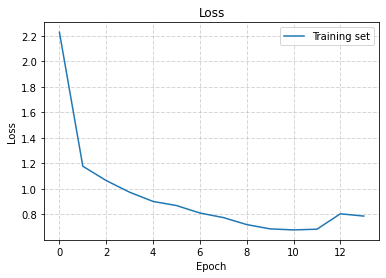

In [100]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

# make predictions

## load/create generative model and function

Since we only want to feed in a single ingredient list that we want it to suggest additions to, we need to rebuild the model with a batchsize of 1, otherwise it would require we feed it BATCH_SIZE lists.

In [101]:
SIMPLIFIED_BATCH_SIZE = 1

model_simplified = build_model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    rnn_units=RNN_UNITS,
    batch_size=SIMPLIFIED_BATCH_SIZE)

# load learned weights from saved training model
model_simplified.load_weights('./next_ingred_rnn_raw.h5')

# ---------- OR ----------
# load learned weights from last checkpoint
# model_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_simplified.build(tf.TensorShape([SIMPLIFIED_BATCH_SIZE, None]))  # can't find .build() method in the API docs...

model_simplified.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (1, None, 16)             480       
                                                                 
 lstm_15 (LSTM)              (1, None, 1024)           4263936   
                                                                 
 dense_14 (Dense)            (1, None, 30)             30750     
                                                                 
Total params: 4,295,166
Trainable params: 4,295,166
Non-trainable params: 0
_________________________________________________________________


Note on the <code>tf.random.categorical()</code> line: current understanding is that the output of dense layer should be interpereted as (possibly unnormalized) log-probabilities of what the next character should be. Instead of simply returning the character corresponding to the argmax, we'd like to sample from this probability distribution so that our model doesn't always return the same thing each time (i.e. isn't determininistic). I think we control 'how deterministic' our model will be via the <code>temperature</code> parameter.

Pretty sure <code>tf.random.categorical</code> is the same as sampling from a discrete distribution, but with the input as log-probabilities instead of the PMF.

Question: do when calling the model a second time, do we only need to supply the next character? or the whole string with that character appended?

In [102]:
def generate_text(model, start_string, num_generate=40, temperature=1.0):
    # tokenize start_string
    input_indices = ids_from_chars(tf.strings.unicode_split(start_string, 'UTF-8'))

    generated_text = []

    # batch size = 1
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(tf.expand_dims(input_indices, 0))  # need to expand so this is a batch of size 1
        
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # use categorical distribution to predict the next character
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # pass predicted character as the next input to the model along with previous hidden state
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = str_from_char_array(chars_from_ids(input_indices[0]))

        generated_text.append(next_character)

    return(start_string + ''.join(generated_text))

## output

In [110]:
print(generate_text(model_simplified, 'onion\n', num_generate=100, temperature=.7))

onion
pilk sauce
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣
